## Viral response profile from phage display immunoprecipitation
This notebook analyzes viral response profile from virScan for patient (P), three family members (R1, R2 and R3) and two unrelated controls (C1 and C2). This analysis has been discussed in Figure 3 and refering text in main manuscript. Following has been covered in this notebook.

1. Viral Response profile
2. Principal Component Analysis (PCA) for microbial peptide enrichment profile.
3. Extracting peptides that drives the differnce in microbial response among subjects.

* Note: we are showing the already generated figure for github version. However, the same can be generated by offline version once downloaded.


In [25]:
# path defintiion
dataDir = "../curatedData/"
codeDir = "../modules/"
figuDir = "../Figures/"

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy as sp
from IPython.display import Image
import sys, os
import importlib
import altair as alt
sys.path.append(codeDir)
import viralResponse as vRP
importlib.reload(vRP)

<module 'viralResponse' from '../modules/viralResponse.py'>

### [Viral response profile](#vresponse1)
We performed virScan experimet to identify IgG profile against large-scale microbial peptide library. Useing Phage-Immunoprecipitation Sequencing (PhIP-Seq), for each sample microbial peptides against which antibodies are present in blood has been enriched. With discussed methodology (see manuscript), we establish statistical significance of each peptide enrichment and analyzed per Species as well as per peptide

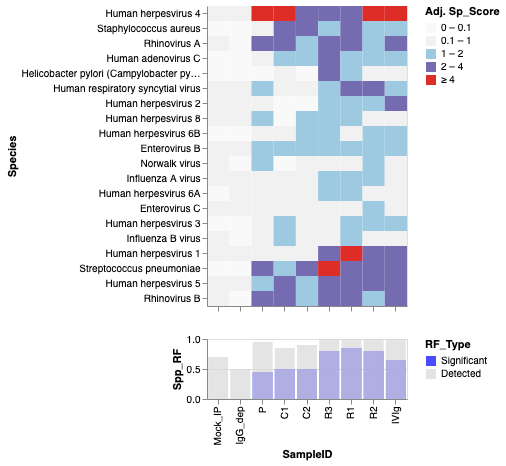

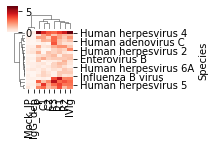

In [35]:
#load data
sppScore = pd.read_csv("../curatedData/PhipSeqData/virscan_skt4Fam_filteredSpScore.csv").set_index("Species")
# gen data plot
fig3a = vRP.vsAltPLot(sppScore)
# fig3a
Image(filename=figuDir+"Fig3A_viralResponseProfile.png")

**Figure3A&B** : Heatmap shows adjusted species score for significant species (Adj. Sp. Score = 1 for at-least one sample) for all samples. Bar plot at bottom shows fraction of significantly (blue) enriched species and species for which at-least on epeptide has been enriched (detected) for each sample.

### Analysis of Enriched Peptides ###
Here we examine difference in enriched profile at microbial peptides in samples. 
1. First, we perform Principal component analysis (PCA) to analyze the profile of peptide enrichment in all samples. 
2. Next, we tease-out the peptides which are contributing maximum for towards two major components.

In [17]:
# load data This is a subset of with peptides that are enriched in at-leat one of the sample and non of the beads
pval_a1 = pd.read_csv(dataDir+"PhipSeqData/pval_virscan_at1Enriched_annot.csv").set_index("id")
_testSamples = ['P','R1','R2','R3','C1','C2']
pval_a1sample = pval_a1[_testSamples]
print ("Peptide enriched in at-lear one samples=",pval_a1.shape[0])

Peptide enriched in at-lear one samples= 4755


In [18]:
#drop peptides that are not enriched in at-least n_dropSamples
n_dropSamples = len(_testSamples)-1 #_testSamples/2
_id_atleast1 = set(pval_a1sample[pval_a1sample>=2.3].dropna(thresh=n_dropSamples).index)
print ("Selected peptide =", len(_id_atleast1))
pval_a1_sample = pval_a1sample.loc[_id_atleast1].reset_index().drop_duplicates(subset='id').set_index('id')
print (pval_a1_sample.shape)

Selected peptide = 196
(196, 6)


In [19]:
pval_a1_x = pval_a1.loc[_id_atleast1][['P','R1','R2','R3','C1','C2','IVIg','IgG_Depleted','mockIP']]
pval_a1_x = pval_a1_x.reset_index().drop_duplicates(subset='id').set_index('id')
print (pval_a1_x.shape)

(196, 9)


First two component covers a variance of: [0.47388545 0.7731629 ]


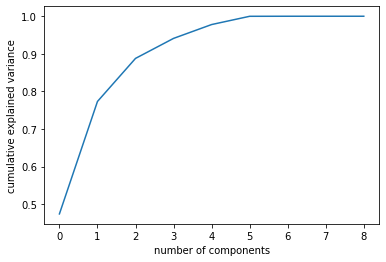

In [20]:
pca = PCA().fit(pval_a1_x.transpose().values)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
print ("First two component covers a variance of:" ,np.cumsum(pca.explained_variance_ratio_[:2]))

In [21]:
pca = PCA(3)
projected = pca.fit_transform(pval_a1_x.transpose().values)
print (projected.shape)
pc_df = pd.DataFrame(data=projected,columns=['PC1','PC2','PC3',])
pc_df['name'] = pval_a1_x.columns
pc_df.loc[pc_df[pc_df.name=='P'].index,'sType'] = 'Patient'
pc_df.loc[pc_df[pc_df.name.isin(['R1','R2','R3'])].index,'sType'] = 'Family'
pc_df.loc[pc_df[pc_df.name.isin(['C1','C2'])].index,'sType'] = 'Control'
pc_df.loc[pc_df[pc_df.name.isin(['IgG_Depleted','mockIP'])].index,'sType'] = 'Neg. Control'
pc_df.loc[pc_df[pc_df.name=='IVIg'].index,'sType'] = 'IVIg'

(9, 3)


In [22]:
pc_df

PC1         PC2         PC3          name         sType
0   45.088066  250.911453  -72.331098             P       Patient
1   34.447156  -20.765159    2.229354            R1        Family
2  290.671650 -117.593521  -38.099295            R2        Family
3   26.131325   55.053738  159.235295            R3        Family
4   -1.412064  -33.354215   -9.008028            C1       Control
5   11.402984   26.470396   29.818738            C2       Control
6 -130.251150  -50.112812  -22.126786          IVIg          IVIg
7 -137.987195  -55.329119  -24.846754  IgG_Depleted  Neg. Control
8 -138.090773  -55.280762  -24.871427        mockIP  Neg. Control

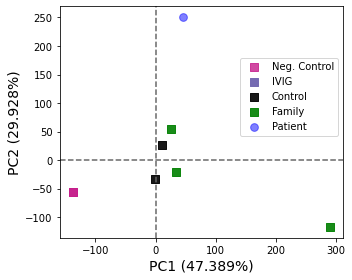

In [23]:
plt.figure(figsize=(5,4))
_negC = pc_df[pc_df.sType=="Neg. Control"]
plt.scatter(_negC.PC1,_negC.PC2,c="#c51b8a",alpha=0.8,marker="s",\
            label="Neg. Control",s=60)

_posC = pc_df[pc_df.sType=="IVIG"]
plt.scatter(_posC.PC1,_posC.PC2,c="#756bb1",marker="s",label="IVIG",s=80)

_control  =  pc_df[pc_df.sType=="Control"]#'-tv Control']
plt.scatter(_control.PC1,_control.PC2,c="k",alpha=0.9,marker="s",\
            label="Control",s=60)

_fam  =  pc_df[pc_df.sType=="Family"]#'-tv Control']
plt.scatter(_fam.PC1,_fam.PC2,c="g",alpha=0.9,marker="s",\
            label="Family",s=60)

_p1 = pc_df[pc_df.sType=="Patient"]#'-tv Control']
plt.scatter(_p1.PC1,_p1.PC2,c="b",marker="o",alpha=0.5,label="Patient",s=60)


plt.axhline(0,0,linestyle='--',color='0.4')
plt.axvline(0,0,linestyle='--',color='0.4')
# plt.ylim(-6,6)
# plt.xlim(-8,8)
plt.legend(ncol=1,bbox_to_anchor=(1,0.8))
# plt.legend(loc=0)
plt.xlabel('PC1 ({}%)'.format(round(pca.explained_variance_ratio_[0]*100,3)),fontsize=14)
plt.ylabel('PC2 ({}%)'.format(round(pca.explained_variance_ratio_[1]*100,3)),fontsize=14)
plt.tight_layout()
# plt.savefig("../Figures/peptide_1233_enrichedProfile.pdf")

**PCA** of filtered enriched peptides (n=196) shown in first two principal components that covers a variance of > 77.3% among samples. Each dot in the plot indicates a sample color coded as per sample type.

### Extracting peptides that drives the differnce in microbial response among subjects.

Cut-off threshold * 70 percentile 6.555821056051202
Species
Enterovirus B                                           5
Human adenovirus C                                      1
Human cytomegalovirus (HHV-5) (Human herpesvirus 5)     1
Human herpesvirus 4                                    13
Human herpesvirus 5                                     2
Rhinovirus A                                            6
Streptococcus pneumoniae                                3
dtype: int64


Species
Enterovirus B                5
Human herpesvirus 4         13
Human herpesvirus 5          2
Rhinovirus A                 6
Streptococcus pneumoniae     3
dtype: int64

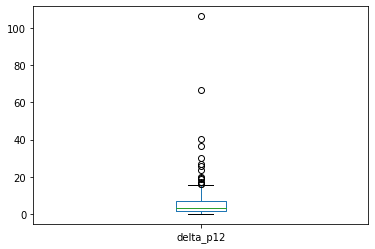

In [24]:
# extract loading factors
loadings = pca.components_.transpose() * np.sqrt(pca.explained_variance_)
df_comp = pd.DataFrame(data=loadings,columns=['pc1','pc2','pc3'])
df_comp['index'] = pval_a1_x.index
df_comp_anno = df_comp.set_index('index').join(pval_a1.loc[pval_a1_x.index][['Species','Protein.names','Entry','start','end']])

df_comp_anno['delta_p12'] = abs(df_comp_anno['pc1']-df_comp_anno['pc2'])
df_comp_anno.delta_p12.plot(kind='box')

fc_delta = df_comp_anno.delta_p12.quantile(0.70)
print ("Cut-off threshold * 70 percentile", fc_delta)
_fc = df_comp_anno[(abs(df_comp_anno.pc1)>fc_delta)&
                   (abs(df_comp_anno.pc2)>fc_delta)]
print (_fc.groupby('Species').size())
spHigh = _fc.groupby('Species').size()[_fc.groupby('Species').size()>=2]
_fcSelected = _fc[_fc.Species.isin(spHigh.index)]
_fcSelected.groupby('Species').size()

In [26]:
ap= alt.Chart(df_comp_anno,width=250,height=200).mark_point(color='gray').encode(
x= 'pc1',
y='pc2',
)
sp = alt.Chart(_fcSelected,width=250,height=200).mark_circle(size=80).encode(
    x=alt.X('pc1',axis=alt.Axis(title='Contribution to PC1')),
    y=alt.Y('pc2',axis=alt.Axis(title='Contribution to PC2')),
    color=alt.Color('Species')
    
)
dx=alt.Chart(df_comp_anno,width=250).mark_boxplot().encode(x='delta_p12')
splot = alt.vconcat(dx,ap+sp).resolve_scale(color='independent')

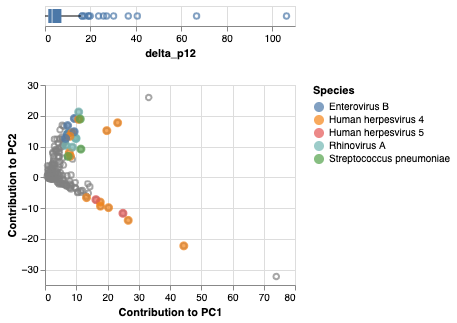

In [28]:
# splot
Image(filename=figuDir+"Fig3D_pcaContribution.png")

**Distribution of peptide contribution** in PCA and Scatter plot showing **significant species driving the difference** 

In [29]:
_fc['spIndex'] = ["{}|{}:{}-{}".format(_fc.loc[i,'Species'],_fc.loc[i,'Entry'],_fc.loc[i,'start'],_fc.loc[i,'end'])
                                      for i in _fc.index]

pvDE = pval_a1_x.loc[_fc.index].join(_fc['spIndex']).set_index('spIndex')
pvDE = pvDE.drop(pvDE.loc[pvDE.index.str.contains('cytomegalovirus')].index,axis=0)

<ipython-input-29-5e0222e70dd7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _fc['spIndex'] = ["{}|{}:{}-{}".format(_fc.loc[i,'Species'],_fc.loc[i,'Entry'],_fc.loc[i,'start'],_fc.loc[i,'end'])


/Users/tkhan/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:1204: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


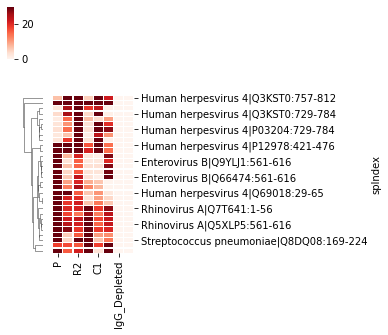

In [30]:
cmx = sns.clustermap(pvDE.drop(['IVIg'],axis=1),cmap='Reds',vmin=0,vmax=30,linewidth=0.1,figsize=(2,4),col_cluster=False)

In [31]:
cmx_aplot = pd.melt(cmx.data2d.reset_index(),id_vars=['spIndex']).rename({'variable':'SampleName','value':'EnrichmentScore'},axis=1)

In [32]:
bplot = alt.Chart(cmx_aplot,height=350,width=150).mark_rect().encode(
x = alt.X('SampleName',sort=list(cmx.data2d.columns)),
    y= alt.Y('spIndex',axis=alt.AxisConfig(labelLimit=10000,title=None)),
    color=alt.Color('EnrichmentScore',scale=alt.Scale(domain=(1,30)))
)

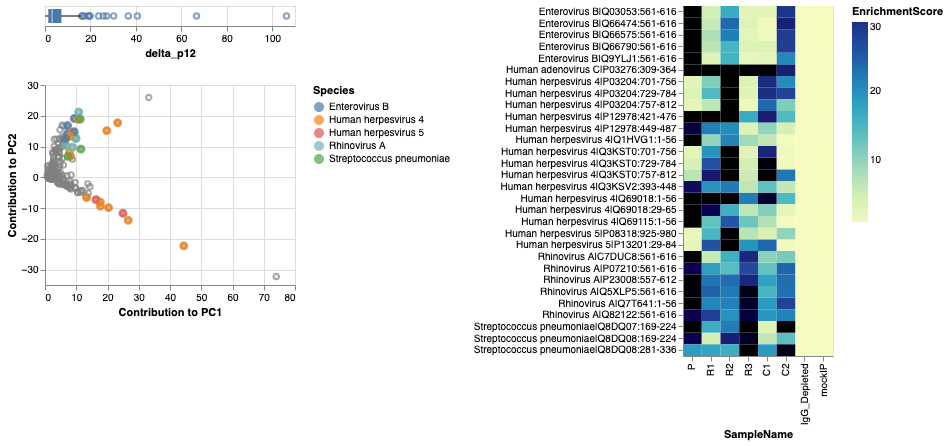

In [34]:
# alt.hconcat(splot,bplot)
Image(filename=figuDir+"EFig3Dx.png")

**Heatmap on right** peptides that drives maximum difference in enrichment profile among subjects. 